In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import io
import h5py
import tempfile
from datetime import datetime

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from sqlalchemy import create_engine, MetaData, Table, Column, Float
from sqlalchemy import Integer, String, Text, DateTime, LargeBinary
import json
from sqlalchemy import create_engine 
from sqlalchemy.exc import SQLAlchemyError
import cryptography
plt.rcParams['font.family'] = 'MALGUN GOTHIC'
plt.rcParams['axes.unicode_minus'] = False

In [255]:
df = pd.read_csv("C:/Users/user-pc/Documents/ai-proj2-class4/20.data-preprocessing/대기오염물질_데이터셋/대기오염물질_데이터셋.csv", encoding="UTF-8")
df = df[['datetime', 'region', 'co', 'so2', 'no2', 'o3']]

with open('C:/Users/user-pc/Documents/ai-proj2-class4/20.data-preprocessing/대기오염물질_데이터셋/db-config.json', 'r') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")
conn = engine.connect()

In [256]:
metadata = MetaData()
models_table = Table(
    "models", metadata,
    Column("id", Integer, primary_key=True),
    Column("name", String(100)),
    Column("type", String(100)),
    Column("version", String(50)),
    Column("description", Text),
    Column("created_at", DateTime, default=datetime.utcnow),
    Column("data", LargeBinary)
)

forecast_table = Table(
    "forecast_results", metadata,
    Column("id", Integer, primary_key=True),
    Column("region", String(50)),
    Column("pollutant", String(50)),
    Column("forecast_date", DateTime),
    Column("predicted_value", String(50)),
    Column("created_at", DateTime)
)

air_pollution_pred_table = Table(
    "air_pollution_day_pred", metadata,
    Column("id", Integer, primary_key=True, autoincrement=True),
    Column("datetime", DateTime),
    Column("region", String(50)),
    Column("co", Float),
    Column("no2", Float),
    Column("so2", Float),
    Column("o3", Float)
)
metadata.create_all(engine)

In [257]:
df

,datetime,region,co,so2,no2,o3
0,2017-01-01 01:00:00,강남구,0.8,0.005,0.040,0.002
1,2017-01-01 01:00:00,강동구,0.9,0.004,0.042,0.002
2,2017-01-01 01:00:00,강북구,1.2,0.004,0.046,0.001
3,2017-01-01 01:00:00,강서구,1.3,0.007,0.070,0.002
4,2017-01-01 01:00:00,관악구,1.5,0.006,0.075,0.004
...,...,...,...,...,...,...
1401619,2023-12-31 00:00:00,영등포구,0.6,0.002,0.031,0.014
1401620,2023-12-31 00:00:00,용산구,0.6,0.002,0.034,0.010
1401621,2023-12-31 00:00:00,은평구,0.9,0.002,0.009,0.031
1401622,2023-12-31 00:00:00,중구,0.6,0.003,0.030,0.016


In [258]:
# 전처리 및 시퀀스 생성 함수
def create_sequences(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

def prepare_series(df, region, pollutant):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df[df['region'] == region].copy()
    df.set_index('datetime', inplace=True)
    series = df[pollutant].resample('d').mean().interpolate(method='spline', order=3)
    return series.dropna()

In [259]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def lstm_evaluate_past(series, region, pollutant, window_size=48):
    print(f"[{region} - {pollutant.upper()}] 과거 검증 시작")

    # 1. 결측 제거 + 일 단위 리샘플링
    series = series.dropna().resample('d').mean().interpolate('spline', order=3)

    # 2. 학습/테스트 분할
    train_series = series[:'2022-12-31']
    test_series = series['2023-01-01':]

    if len(train_series) < window_size or len(test_series) < window_size:
        print("→ 데이터 길이 부족으로 학습 불가")
        return

    # 3. 스케일링
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_series.values.reshape(-1, 1))

    # 4. 시퀀스 생성
    X_train, y_train = create_sequences(train_scaled, window_size)
    X_test, y_test = create_sequences(test_scaled, window_size)

    # 5. 모델 학습
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping

    model = Sequential([
        Input(shape=(window_size, 1)),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_split=0.1, callbacks=[EarlyStopping(patience=5)], verbose=0)

    # 6. 예측
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 7. 평가 및 시각화
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_true[:60], label="실제값", linewidth=2)
    plt.plot(y_pred[:60], label="예측값", linewidth=2)
    plt.title(f"[{region} - {pollutant.upper()}] 과거 테스트 예측 (2023~2025)")
    plt.legend()
    plt.grid()
    plt.show()

    return rmse

[용산구 - CO] 과거 검증 시작
RMSE: 0.0892


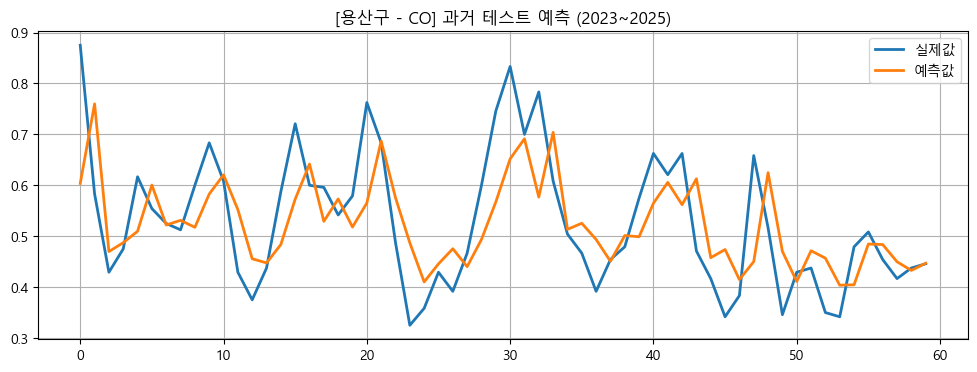

0.08924817369713477

In [260]:
df['datetime'] = pd.to_datetime(df['datetime'])

# 1. 학습/테스트 검증 (LSTM 성능 평가용)
df_eval = df.copy()
df_eval.set_index('datetime', inplace=True)
region = "용산구"
pollutant = "co"
series = df_eval[df_eval['region'] == region][pollutant]
lstm_evaluate_past(series, region, pollutant)

In [261]:
def save_forecast_to_db(df_pred, region, pollutant):
    if df_pred is None or df_pred.empty:
        print(f"[{region} - {pollutant}] 예측 결과 없음 → 저장 생략")
        return

    with engine.connect() as conn:
        try:
            rows = [
                {
                    "region": region,
                    "pollutant": pollutant,
                    "forecast_date": row['date'],
                    "predicted_value": str(row['predicted_value']),
                    "created_at": datetime.now(timezone.utc)
                }
                for _, row in df_pred.iterrows()
            ]
            conn.execute(forecast_table.insert(), rows)
            print(f"[{region} - {pollutant}] 예측 결과 DB 저장 완료 ✅")
        except Exception as e:
            print(f"[{region} - {pollutant}] 예측 결과 저장 실패 ❌: {e}")

def forecast_future_lstm(series, region, pollutant, days=30):
    print(f"\n[{region} - {pollutant}] 예측 시작")

    series.index = pd.to_datetime(series.index)
    series = series.sort_index()

    if len(series) < 100:
        print(f"[{region} - {pollutant}] 데이터 부족 (<100일)")
        return None, None

    df_values = pd.DataFrame(series)
    scaler = RobustScaler()
    scaled = scaler.fit_transform(df_values)

    X, y = create_sequences(scaled, window_size=48)
    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]

    model = Sequential([
        Input(shape=(48, X.shape[2])),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)

    # 예측
    last_seq = scaled[-48:].reshape(1, 48, X.shape[2])
    future_scaled = []

    for _ in range(days):
        next_pred = model.predict(last_seq, verbose=0)[0][0]
        future_scaled.append([next_pred])
        last_seq = np.append(last_seq[:, 1:, :], [[[next_pred]]], axis=1)

    padded = np.hstack([np.array(future_scaled), np.zeros((days, X.shape[2] - 1))])
    future_inv = scaler.inverse_transform(padded)[:, 0]

    today = pd.Timestamp('2025-07-03')  # 기준 날짜
    future_dates = pd.date_range(start=today + pd.Timedelta(days=1), periods=days)

    # ✅ 플롯 (연속 인덱스 기반)
    past_values = series[-30:].values
    combined = np.concatenate([past_values, future_inv])
    x = range(len(combined))

    plt.figure(figsize=(12, 4))
    plt.plot(x[:30], past_values, label="과거 30일", linewidth=2)
    plt.plot(x[30:], future_inv, label="예측 30일", color='red', linewidth=2)
    plt.title(f"[{region}] {pollutant.upper()} 예측 - LSTM")
    plt.xlabel("시간 흐름 (연속 인덱스)")
    plt.ylabel("농도")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ✅ .h5 저장
    with tempfile.NamedTemporaryFile(suffix=".h5", delete=False) as tmp:
        model.save(tmp.name)
        tmp.seek(0)
        model_binary = tmp.read()

    with engine.connect() as conn:
        try:
            insert_stmt = models_table.insert().values(
                name=f"{region}_{pollutant}_predict_model",
                type="LSTM",
                version="v2.0",
                description=f"{region} - {pollutant} 단변량 LSTM",
                created_at=datetime.now(timezone.utc),
                data=model_binary
            )
            conn.execute(insert_stmt)
            conn.commit()
            print(f"[{region} - {pollutant}] 모델 저장 완료 ✅")
        except Exception as e:
            print(f"[{region} - {pollutant}] 모델 저장 실패 ❌: {e}")

    return pd.DataFrame({'date': future_dates, 'predicted_value': future_inv}), model

# 전체 반복 실행
def forecast_region_all_pollutants(df, region, days=30):
    pollutants = ['co', 'so2', 'no2', 'o3']
    results = {}

    print(f"\n📍 {region} 지역 {days}일 예측 시작")

    for pollutant in pollutants:
        series = prepare_series(df.copy(), region, pollutant)
        pred_df, model = forecast_future_lstm(series, region, pollutant, days=days)

        if pred_df is not None:
            save_forecast_to_db(pred_df, region, pollutant)
            results[pollutant] = pred_df
        else:
            print(f"[{pollutant}] 예측 실패 또는 데이터 부족")

    return results

def merge_and_save_daily_forecast(results_dict, region):
    """
    results_dict: {'co': df_co, 'so2': df_so2, ...} 형식의 예측 결과 모음
    각 df는 ['date', 'predicted_value'] 형식
    """
    try:
        # date 기준으로 병합
        merged_df = None
        for pollutant, df in results_dict.items():
            df = df.rename(columns={'predicted_value': pollutant})
            if merged_df is None:
                merged_df = df
            else:
                merged_df = pd.merge(merged_df, df, on='date')

        # region 추가
        merged_df['region'] = region
        merged_df.rename(columns={'date': 'datetime'}, inplace=True)

        # 저장
        with engine.connect() as conn:
            rows = merged_df[['datetime', 'region', 'co', 'no2', 'so2', 'o3']].to_dict(orient='records')
            conn.execute(air_pollution_pred_table.insert(), rows)
            conn.commit()
            print(f"✅ {region}의 전체 예측 결과 DB 저장 완료 ({len(rows)}일치)")
    except Exception as e:
        print(f"❌ DB 저장 중 오류 발생: {e}")


📍 용산구 지역 30일 예측 시작

[용산구 - co] 예측 시작


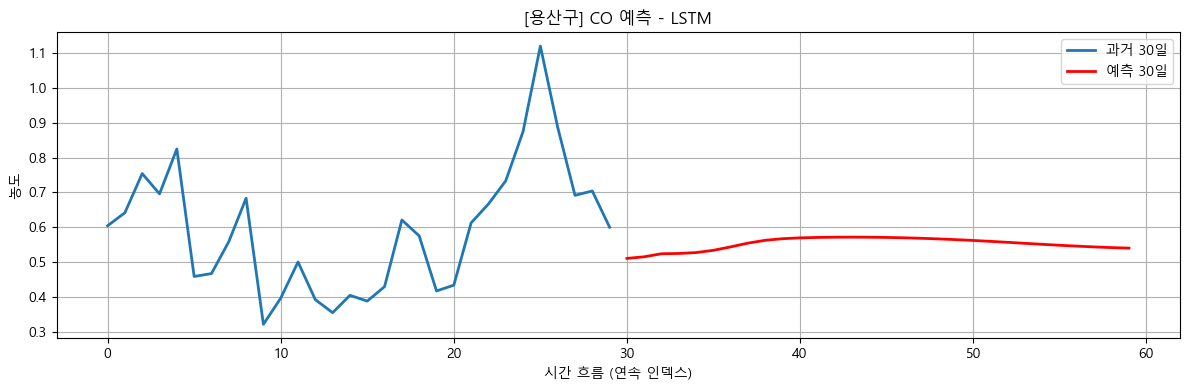

[용산구 - co] 모델 저장 완료 ✅
[용산구 - co] 예측 결과 DB 저장 완료 ✅

[용산구 - so2] 예측 시작


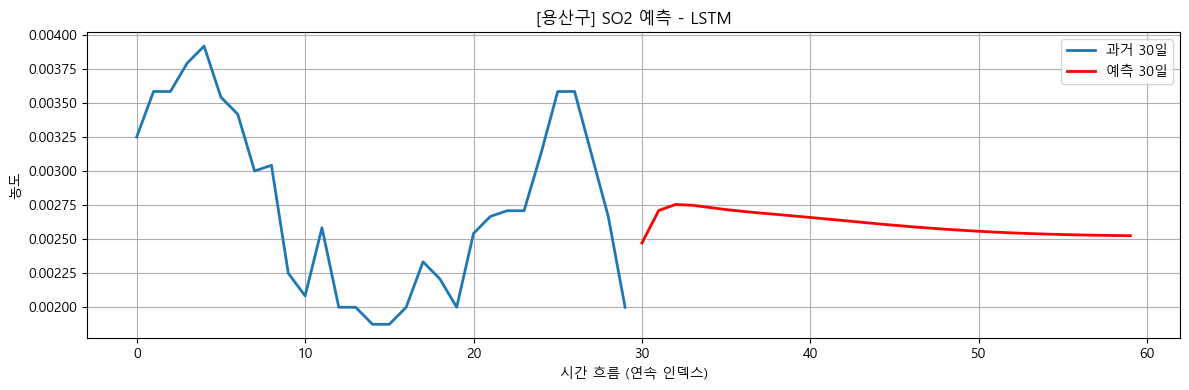

[용산구 - so2] 모델 저장 완료 ✅
[용산구 - so2] 예측 결과 DB 저장 완료 ✅

[용산구 - no2] 예측 시작


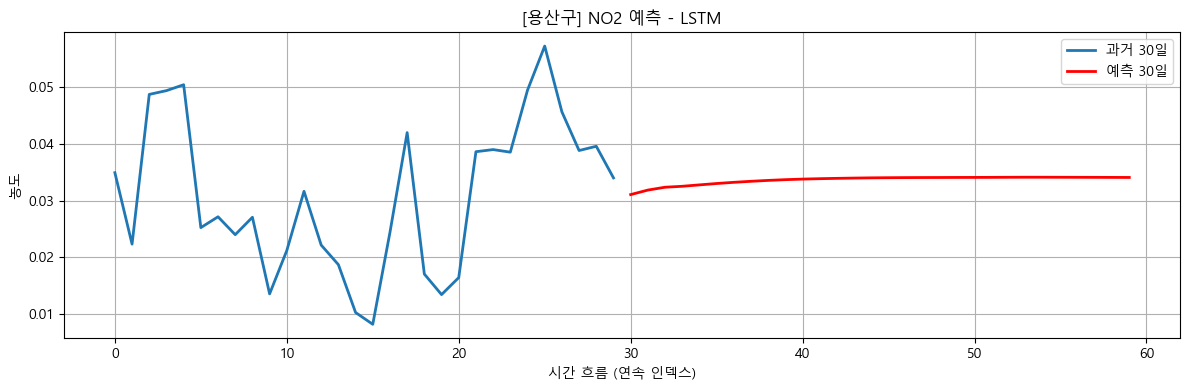

[용산구 - no2] 모델 저장 완료 ✅
[용산구 - no2] 예측 결과 DB 저장 완료 ✅

[용산구 - o3] 예측 시작


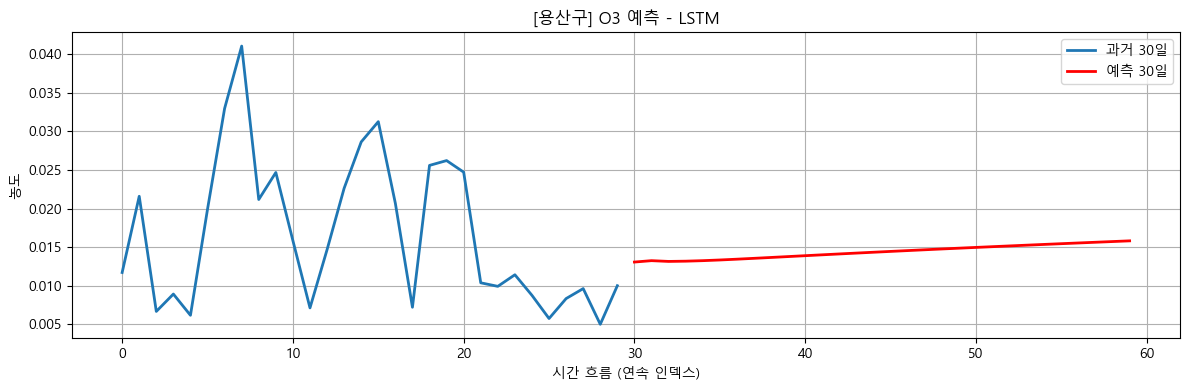

[용산구 - o3] 모델 저장 완료 ✅
[용산구 - o3] 예측 결과 DB 저장 완료 ✅
✅ 용산구의 전체 예측 결과 DB 저장 완료 (30일치)


In [262]:
results = forecast_region_all_pollutants(df, region='용산구', days=30)
merge_and_save_daily_forecast(results, region='용산구')